In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import json
import pandas as pd
from scipy.interpolate import interp1d
sns.set(style="whitegrid")

In [11]:
models = [
    'dpp',
    'qmix', 
    'coma', 
#     'iql', 
#     'centralV',
    'noisemix', 
    'vdn',
    'qtran'
]

model_names = {
    'dpp': 'QPDPP (Ours)',
    'qmix': 'QMIX', 
    'coma': 'COMA', 
    'iql': 'IQL', 
    'centralV': 'CentralV',
    'noisemix': 'MAVEN', 
    'vdn': 'VDN',
    'qtran': 'QTRAN'
}

game = 'Blocker-v0'
df = None

fields = ['ep_return_T', 'ep_return', 'return_mean_T', 'return_mean', 'test_return_mean_T', 'test_return_mean']

def smoothing(vs,p=0.6, model='qmix'):
    rsts = []
    last = vs[0]
    for i, v in enumerate(vs):
        if model == 'dpp': 
            v += 1
        if i == 0:
            smoothed = v
        else:
            if model in ['coma', 'qtran'] and i < 150 and i >80 and v > -30:
                smoothed = -37.
            else:
                smoothed =  last*p + (1-p)*v
        rsts.append(smoothed)
        last = smoothed
    return np.array(rsts)

for model in models:
    log_dir = '../result_final/grid/{}*/{}/*/info.json'.format(game, model)
    print(log_dir)
    log_paths = glob(log_dir)
    print(log_paths)
    x_inx = None
    model_count = 0
    for path in log_paths:
        if model_count >5:
            break
        try:
            log = json.load(fp=open(path, 'r'))
            log_selected = {field:log[field] for field in fields if field in log.keys()}
            
        except:
            print('fail', path)
            continue

        y_column = 'return_mean'
        x_column = 'return_mean_T'
        x = np.asarray(log_selected[x_column])
        if len(x) < 200:
            print('too short', path)
            continue
        print(x[-1])
        if x_inx is None:
            x_inx = x
            if x_inx[-1] + 6000 > 100000:
                x_inx[-1]= 100000
        y = smoothing(smoothing(np.asarray(log_selected[y_column]), model=model))
        x = x_inx[0:len(y)]
        print(x.shape, y.shape)
        log_df = pd.DataFrame(list(zip(x, y)), 
           columns =['Step', 'Return']) 
        log_df['Model'] = log_df['Step'].apply(lambda x: model_names[model])
        log_df['run'] = log_df['Step'].apply(lambda x: path)
        if df is None:
            df = log_df

        else:
            df = pd.concat([df, log_df], ignore_index=True)
        print(path)
        model_count += 1


df = df.dropna()
df = df.astype({'Step': 'int32', 'Return': 'float32'})

../result_final/grid/Blocker-v0*/dpp/*/info.json
['../result_final/grid/Blocker-v0/dpp/done_1/info.json', '../result_final/grid/Blocker-v0/dpp/1/info.json', '../result_final/grid/Blocker-v0/dpp/3/info.json', '../result_final/grid/Blocker-v0-71-30/dpp/1/info.json', '../result_final/grid/Blocker-v0-1/dpp/6/info.json', '../result_final/grid/Blocker-v0-1/dpp/1/info.json', '../result_final/grid/Blocker-v0-1/dpp/4/info.json', '../result_final/grid/Blocker-v0-1/dpp/3/info.json', '../result_final/grid/Blocker-v0-1/dpp/2/info.json', '../result_final/grid/Blocker-v0-1/dpp/5/info.json']
499672
(996,) (996,)
../result_final/grid/Blocker-v0/dpp/done_1/info.json
499649
(993,) (993,)
../result_final/grid/Blocker-v0/dpp/1/info.json
498846
(991,) (991,)
../result_final/grid/Blocker-v0/dpp/3/info.json
fail ../result_final/grid/Blocker-v0-71-30/dpp/1/info.json
too short ../result_final/grid/Blocker-v0-1/dpp/6/info.json
too short ../result_final/grid/Blocker-v0-1/dpp/1/info.json
too short ../result_final/

/Users/yingwen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


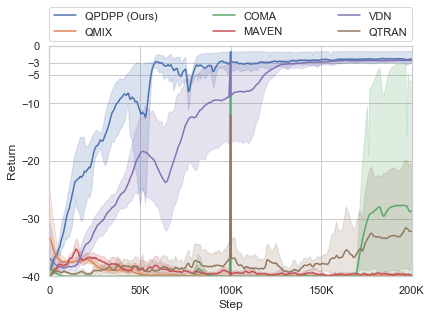

In [12]:
plt.figure(figsize=(6,4))
sns.set(font_scale=1., style="whitegrid")
ax = sns.lineplot(x="Step", y="Return",
             hue="Model", err_style='band',
             data=df)
# plt.title(game)
plt.tight_layout(pad=1)
ax.set_xlim(0., 200000)
ax.set_ylim(-40., 0.)
ax.set_yticks([-40, -30, -20, -10, -5, -3, 0])
ax.set_xticks([0,  50000,  100000, 150000,  200000])
ax.set_xticklabels(['0',  '50K',  '100K',  '150K',  '200K'])
# ax.set_xlim(0., 500000)
# ax.set_ylim(-40., 0.)
# ax.set_yticks([-40, -30, -20, -10, -5, -3, 0])
# ax.set_xticks([0,  100000,200000, 300000, 400000, 500000])
# ax.set_xticklabels(['0', '100K', '200K', '300K', '400K', '500K'])
# lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

handles, labels = ax.get_legend_handles_labels()

# legend()
lgd = ax.legend(handles=handles[1:], labels=labels[1:], 
                bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
# lgd = plt.legend() 
plt.savefig('{}_lc.pdf'.format(game), bbox_extra_artists=(lgd,), bbox_inches='tight')

In [5]:
# log_paths = glob('./results/grid/{}/dpp/*/info.json'.format(game))
# path = log_paths[-1]
# log = json.load(fp=open(path, 'r'))
#         log_selected = {field:log[field] for field in fields}

In [6]:
# log.keys()